In [ ]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


using the famous FER-2013 as dataset to train and test model

In [ ]:
Datadirectory_train='/content/drive/MyDrive/ML_Project/train'
Datadirectory_test='/content/drive/MyDrive/ML_Project/test'
# path=os.path.join(Datadirectory,"")
# print(path)
Classes=['happy','sad']

Changing the size of image from 48X48 to 224X224 to easily put it in the model(now doing it only for whole dataset)

In [ ]:
# training_data=[]
# def create_training_data():
#   for Category in Classes:
#     path=os.path.join(Datadirectory_train,Category)
#     class_num=Classes.index(Category)
#     for img in os.listdir(path):
#       img_arr=cv2.imread(os.path.join(path,img))
#       new_array=cv2.resize(img_arr,(224,224))
#       training_data.append([new_array,class_num])

# create_training_data()


In [ ]:
# print((training_data[0][0]))
# print((training_data[0][1]))

In [ ]:
# import random
# random.shuffle(training_data)
# X=[]
# Y=[]
# for features,label in training_data:
#   X.append(features)
#   Y.append(label)
# X=np.array(X).reshape(-1,224,224,3) #changing dimensions to properly allow model to work



In [ ]:
# X=X/255

In [ ]:
# print(len(X),len(X[0]),len(X[0][0]),(X[0][0][0]))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# model=tf.keras.applications.MobileNetV2() #use MobileNetV2 archutecture pre-training model, as it being light weight we can use it for live demo
from keras.applications.vgg16 import VGG16, preprocess_input


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
traingen = train_generator.flow_from_directory(Datadirectory_train,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=Classes,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(Datadirectory_train,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=Classes,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(Datadirectory_test,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=Classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
print(len(traingen),len(traingen[0][0]))

27 64


In [ ]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 53.1 MB/s 


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

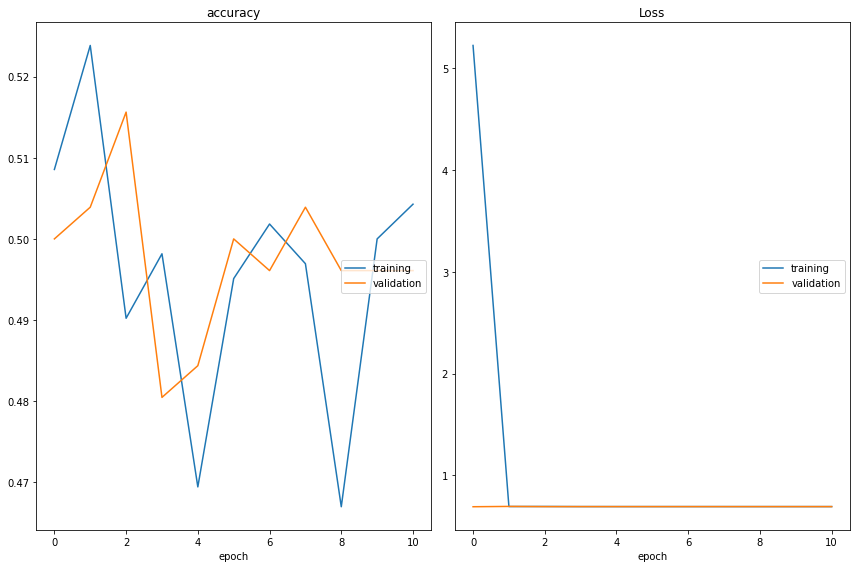

accuracy
	training         	 (min:    0.467, max:    0.524, cur:    0.504)
	validation       	 (min:    0.480, max:    0.516, cur:    0.496)
Loss
	training         	 (min:    0.693, max:    5.226, cur:    0.693)
	validation       	 (min:    0.692, max:    0.695, cur:    0.693)
26/26 [==============================] - 34s 1s/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4961


In [ ]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

400/400 [==============================] - 95s 237ms/step


Doing transfer learning to make the model learn classes from last step, and hence we won't have to train the whole model from start, and we can use the already existing weights and biases